### Relevant libraries

In [1]:
push!(LOAD_PATH, "../src/")
using PyPlot, Logging
Logging.configure(level=DEBUG, filename="oracle_linear_bump.log")

Logger(root,DEBUG,IOStream(<file oracle_linear_bump.log>),root)

In [2]:
# start the parallel workers
if length(workers()) > 1
    rmprocs(workers())
end
addprocs(11)
@everywhere push!(LOAD_PATH, "../src/")
@everywhere using GP, Optim

### Theoretically calculated performances

In [3]:
# generates a bump function
@everywhere function bump(θs, δ)
    return (1 - exp(-δ^2))^2 ./ (1 - 2*exp(-δ^2)*cos(θs - π) + exp(-2*δ^2))
end

# simulate the decoding of a bump function
@everywhere function bump_r2(M, σn, Δ, δ; res=1024, plt=false)
    ker = Kernel(Δ)
    # tuning curves
    θs, tcs = tc(res, M, ker)
    y = bump(θs, δ)
    # responses
    r = tcs + randn(res, M) * σn
    # best output weights
    w1 = inv(tcs' * tcs / res + σn^2 * eye(M)) * tcs' * y / res
    
    if plt
        plot(θs, y, "k-")
        plot(θs, r * w1, "r--")
    end

    return 1 - sum((r * w1 - y).^2) / sum(y.^2)
end

In [4]:
# max r2 performance (decoding a DC signal)
@everywhere function r2_max(M, σn, Δ)
    return 1 / (1 + 1/ (tanh(Δ/2) * M / σn^2))
end

# given bump width, what is the performance?
@everywhere function r2_delta(M, σn, Δ, δ; tol=1e-6)
    f2 = 2 * π^2 * 2 / (1 + sech(δ^2)) * tanh(δ^2 / 2)
    
    s = 4*π^2 * tanh(δ^2/2)^2 / (1 + 1 / (M / σn^2 * tanh(Δ/2)))
    k = 1
    while true
        t1 = 4*π^2 * tanh(δ^2/2)^2 * exp(-2*k*δ^2)
        t2 = M / σn^2 * tanh(Δ/2) * exp(-k*Δ)
        snew = s + 2 * t1 / (1 + 1/t2)
        if abs((snew - s) / s) < tol; break; end
        s = snew; k=k+1
    end
    return s / f2
end

# given required performance, what is the minimal bump width?
@everywhere function delta_min(M, σn, Δ, r)
    if r2_max(M, σn, Δ) < r; return -1; end
    
    return optimize(δ -> (r2_delta(M, σn, Δ, δ) - r)^2, 1e-9, 1).minimum
end

### Minimal tuning width as a function of population size

In [26]:
MsFull = logspace(1, 10, 20) # range of pop size to sweep
σn = sqrt(1) # noise level
M = 500 # number of neurons in the population
Δ = 0.25 # smoothness
r2 = 0.9 # required performance

0.9

In [35]:
# compute the minimal width in a parallel loop
δmins = SharedArray(Float64, length(MsFull))
@sync @parallel for ixM in 1:length(MsFull)
    M = MsFull[ixM]
    δmins[ixM] = 2.78 * delta_min(M, σn, Δ, r2)^2
end;

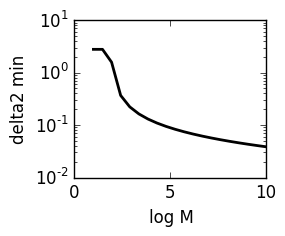

In [36]:
# plot the result
figure(figsize=(3, 2.5))
PyPlot.locator_params(nbins=3)

plot(log10(MsFull), δmins, "k-", linewidth=2)
yscale("log"); ylabel("delta2 min"); xlabel("log M")
tight_layout()

### Example bump decoding

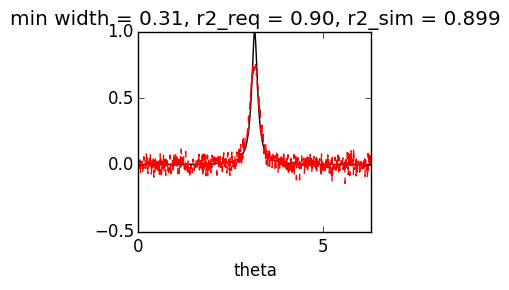

PyObject <matplotlib.text.Text object at 0x7ff738d9c128>

In [10]:
σn = sqrt(1) # noise level
M = 500 # number of neurons in the population
Δ = 0.25 # smoothness
r2 = 0.9 # required performance
dmin = delta_min(500, σn, Δ, r2) # corresponding minimal bump width

figure(figsize=(3, 2.5))
PyPlot.locator_params(nbins=3)
# simulate and plot the result
r2_actual = bump_r2(M, σn, Δ, dmin; plt=true)
xlabel("theta"); xlim([0, 2π])
title(@sprintf("min width = %0.2f, r2_req = %0.2f, r2_sim = %0.3f", dmin, r2, r2_actual))

### Performance (simulated vs theory) as a function of bump width

In [22]:
σn = sqrt(0.1) # noise std
M = 50 # size of the population
Δ = 0.5 # smoothness of manifold
r2 = 0.9 # required performance
δs = logspace(-2, 0, 20) # widths to scan

0.38478864754244557

In [23]:
sim_r2, theory_r2 = SharedArray(Float64, length(δs)), SharedArray(Float64, length(δs))
@sync @parallel for kδ in 1:length(δs)
    δ = δs[kδ]
    sim_r2[kδ], theory_r2[kδ] = bump_r2(M, σn, Δ, δ), r2_delta(M, σn, Δ, δ);
end

11-element Array{Any,1}:
 RemoteRef{Channel{Any}}(2,1,276) 
 RemoteRef{Channel{Any}}(3,1,277) 
 RemoteRef{Channel{Any}}(4,1,278) 
 RemoteRef{Channel{Any}}(5,1,279) 
 RemoteRef{Channel{Any}}(6,1,280) 
 RemoteRef{Channel{Any}}(7,1,281) 
 RemoteRef{Channel{Any}}(8,1,282) 
 RemoteRef{Channel{Any}}(9,1,283) 
 RemoteRef{Channel{Any}}(10,1,284)
 RemoteRef{Channel{Any}}(11,1,285)
 RemoteRef{Channel{Any}}(12,1,286)

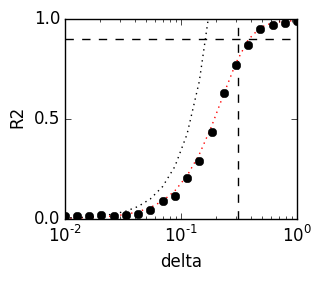

PyObject <matplotlib.text.Text object at 0x7ff7388c5208>

In [37]:
figure(figsize=(3, 2.5))
PyPlot.locator_params(nbins=3)
# lot theory and simulated results
plot(δs, theory_r2, "r:")
plot(δs, sim_r2, "ko")
# plot approximate theory
plot(δs, 2 * δs.^2 / Δ * log(1 + M / σn^2 * tanh(Δ/2)), "k:")
# location of minimal width
δmin = delta_min(M, σn, Δ, r2) # minimal width
# minimal width and the corresponding performance for reference
PyPlot.axvline(δmin, linestyle="--", color="k")
PyPlot.axhline(r2, linestyle="--", color="k")
ylim([0, 1]); xscale("log")
xlabel("delta"); ylabel("R2")